# Bayesian inference of Hubble constant from simulated time delays

In [34]:
import pandas as pd
import csv

# import of standard python libraries
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

In [35]:
#constraining table
tabela_nova = pd.read_csv("data_set.csv", sep=",")
tabela_1 = tabela_nova[tabela_nova['thetaE'] > 0.9] 
tabela = tabela_1[tabela_1['thetaE'] < 1.6] 

In [36]:
df = pd.DataFrame(tabela)
tabela = df.dropna().reset_index(drop=True)
tabela

,Nome,zl,zs,Sigma ap,dSigma ap,thetaE,Survey,theta ap,Theta eff,sigma0,dsigma0,sigma_atm_(arcsec)
0,J0830+5116,0.5300,1.3320,268.00,36.00,1.14,BELLS,1.0,1.100,274.00,37.00,1.8
1,J1215+0047,0.6420,1.2970,262.00,45.00,1.37,BELLS,1.0,1.420,266.00,46.00,1.8
2,J1337+3620,0.5640,1.1820,225.00,35.00,1.39,BELLS,1.0,1.600,227.00,35.00,1.8
3,J1542+1629,0.3520,1.0230,210.00,16.00,1.04,BELLS,1.0,1.450,213.00,16.00,1.8
4,J1545+2748,0.5220,1.2890,250.00,37.00,1.21,BELLS,1.0,2.650,247.00,37.00,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...
100,J2309-0039,0.2905,1.0048,184.00,13.00,1.14,SLACS2017,1.5,2.080,187.00,13.00,1.4
101,J090311.6+003906,0.2997,3.0420,238.58,16.49,1.52,BELLS,1.0,1.815,239.51,16.56,1.8
102,J134429.4+303036,0.6720,2.3010,422.43,96.79,0.92,BELLS,1.0,0.695,440.67,100.97,1.8
103,J110016.3+571736,0.7810,1.6510,265.99,63.34,1.14,BELLS,1.0,5.650,255.17,60.76,1.8


# Simulation choises

In [5]:
# define lens configuration and cosmology 
z_lens =  tabela['zl']
z_source = tabela['zs']
theta_E = tabela['thetaE']

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.) 

# data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)

# generate the psf variables
kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'fwhm': fwhm}
psf_class = PSF(**kwargs_psf)

In [6]:
# lensing quantities
gamma1, gamma2 = param_util.shear_polar2cartesian(phi=-0.5, gamma=0.06)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  # shear values

lista_de_dicionarios = []

for index in tabela['thetaE']:
    
    kwargs_spemd={}
    kwargs_spemd['theta_E'] = index
    kwargs_spemd['gamma'] = 1.98
    kwargs_spemd['center_x'] = 0.0
    kwargs_spemd['center_y'] = 0.0
    kwargs_spemd['e1'] = 0.05
    kwargs_spemd['e2'] = 0.05
    lista_de_dicionarios.append(kwargs_spemd)
    
# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['SPEP', 'SHEAR']
kwargs_lens = [lista_de_dicionarios, kwargs_shear]


lens_model_class_lista= []

for a in range(0,104):
   
    lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens[a], z_source=z_source[a], cosmo=cosmo)
    lens_model_class_lista.append(lens_model_class)
    


# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'
source_x = 0.
source_y = 0.1

# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.2, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.4, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# Image positions
lensEquationSolver = LensEquationSolver(lens_model_class)

x_image_lista = []
y_image_lista = []

for a in range(0, 104):    

    x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, [lista_de_dicionarios[a], kwargs_shear], numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
    x_image_lista.append(x_image)
    y_image_lista.append(y_image)
    

mag_lista = []

for a in range(0,104):
    mag = lens_model_class.magnification(x_image_lista[a], y_image_lista[a], kwargs=[lista_de_dicionarios[a], kwargs_shear])   
    mag_lista.append(mag)
    
    
kwargs_ps_lista = []

for a in range(0, 104):
    kwargs_ps = [{'ra_image': x_image_lista[a], 'dec_image': y_image_lista[a],
                           'point_amp': np.abs(mag_lista[a])*1000}]  
    kwargs_ps_lista.append(kwargs_ps)
    
    
    
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'supersampling_factor': 1}

imageModel_lista = []

for a in range(0, 104):
    imageModel = ImageModel(data_class, psf_class, lens_model_class_lista[a], source_model_class,
                                lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)
    imageModel_lista.append(imageModel)     

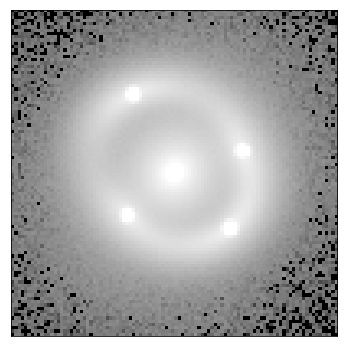

In [7]:
import warnings
warnings.filterwarnings('ignore')
#generate image (Ele cria a imagem)
image_sim = imageModel.image([lista_de_dicionarios[0], kwargs_shear], kwargs_source, kwargs_lens_light, kwargs_ps_lista[0])
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
image_sim = image_sim + bkg + poisson

data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim


kwargs_model = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

# A imagem abaixo é a única lente que estou olhando, é essa imagem que vemos abaixo.

# time delays
time delays are defined in lenstronomy as the difference in light travel path relative to a straight line. Negative values correspond to earlier arrival times. The units are in days

In [37]:
from lenstronomy.Analysis.td_cosmography import TDCosmography

td_cosmo_lista = []
t_days_lista = []
printar_0_lista = []
dt_days_lista = []
dt_measured_lista = []
printar_1_lista = []

for k in range(0,104):

    td_cosmo = TDCosmography(z_lens[k], z_source[k], kwargs_model, cosmo_fiducial=cosmo)   
    td_cosmo_lista.append(td_cosmo)

# time delays, the unit [days] is matched when the lensing angles are in arcsec
    t_days = td_cosmo_lista[k].time_delays([lista_de_dicionarios[k], kwargs_shear], kwargs_ps_lista[k], kappa_ext=0)    
    t_days_lista.append(t_days)
    
    printar_0 = print("the time delays for the images at position ", kwargs_ps_lista[k][0]['ra_image'], kwargs_ps_lista[k][0]['dec_image'], "are: ", t_days_lista[k])   
    printar_0_lista.append(printar_0)

# relative delays (observable). The convention is relative to the first image
    dt_days =  t_days_lista[k][1:] - t_days_lista[k][0]    
    dt_days_lista.append(dt_days)

# and errors can be assigned to the measured relative delays (full covariance matrix not yet implemented)
    dt_sigma = [3, 5, 10] # Gaussian errors
    np.random.seed(2)
# and here a realisation of the measurement with the quoted error bars
    dt_measured = np.random.normal(dt_days_lista[k], dt_sigma)
    dt_measured_lista.append(dt_measured)
   
    printar_1 = print("the measured relative delays are: ", dt_measured_lista[k])
    printar_1_lista.append(printar_1)    

the time delays for the images at position  [-0.63063198  0.84718868  1.04061186 -0.71358134] [ 1.19566337 -0.8455816   0.32896767 -0.65281221] are:  [-93.48214032 -70.74911216 -62.26549017 -50.79170023]
the measured relative delays are:  [21.48275462 30.93531602 21.32847914]
the time delays for the images at position  [-0.77273186  0.98674376  1.22083034 -0.8912551 ] [ 1.40950839 -1.06533012  0.45015143 -0.76809547] are:  [-191.71482466 -151.96296123 -129.49324511 -109.28858807]
the measured relative delays are:  [38.50158989 61.94024542 61.06427564]
the time delays for the images at position  [-0.78512402  0.99897634  1.2364497  -0.90671489] [ 1.42807359 -1.08425858  0.46045127 -0.77803222] are:  [-166.31278749 -132.26536642 -112.44099917  -95.12804272]
the measured relative delays are:  [32.79714752 53.59045418 49.82278381]
the time delays for the images at position  [-0.56915122  0.78744705  0.96172625 -0.6364348 ] [ 1.10244031 -0.7482023   0.27393668 -0.60193549] are:  [-47.377327

# Fermat Potential

In [10]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

lens_cosmo_lista = []
d_fermat_model_lista = []

for k in range(0,104):
    
    lens_cosmo = LensCosmo(z_lens[k], z_source[k], cosmo)
    lens_cosmo_lista.append(lens_cosmo)

    d_fermat_model = lens_cosmo_lista[k].time_delay2fermat_pot(dt=dt_days_lista[k])
    d_fermat_model_lista.append(d_fermat_model)

# Time delay distance

In [11]:
td_distance_lista = []

for k in range(0,104):

    td_distance = td_cosmo_lista[k].ddt_from_time_delay(d_fermat_model_lista[k], dt_measured_lista[k]
                                                        , kappa_s=0, kappa_ds=0, kappa_d=0)
    td_distance_lista.append(td_distance)

# kinematics
Kinematics can provide important complementary information about the lens to constrain cosmography

In [12]:
R_slit = 1. # slit length in arcsec
dR_slit = 1.  # slit width in arcsec
psf_fwhm = 0.7  # Full width at half maximum of the PSF
kwargs_aperture = {'aperture_type': 'slit', 'length': R_slit, 'width': dR_slit, 'center_ra': 0.05, 'center_dec': 0, 'angle': 0}
anisotropy_model = 'OM'
aperture_type = 'slit'

kwargs_numerics_galkin = {'interpol_grid_num': 1000,  # numerical interpolation, should converge -> infinity
                          'log_integration': True,  # log or linear interpolation of surface brightness and mass models
                           'max_integrate': 100, 'min_integrate': 0.001}  # lower/upper bound of numerical integrals
r_ani = 1.    # anisotropy radius
r_eff = 0.2
kwargs_anisotropy = {'r_ani': r_ani}
kwargs_seeing = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm}

from lenstronomy.Analysis.kinematics_api import KinematicsAPI
kin_api_lista = []
vel_disp_lista = []

for l in range(0,104):
    kin_api = KinematicsAPI(z_lens[l], z_source[l], kwargs_model, cosmo=cosmo, 
                        lens_model_kinematics_bool=[True, False], light_model_kinematics_bool=[True], 
                        kwargs_aperture=kwargs_aperture, kwargs_seeing=kwargs_seeing, 
                        anisotropy_model=anisotropy_model, kwargs_numerics_galkin=kwargs_numerics_galkin,
                        sampling_number=10000,  # numerical ray-shooting, should converge -> infinity
                        Hernquist_approx=True)
    kin_api_lista.append(kin_api)

    vel_disp = kin_api_lista[l].velocity_dispersion([lista_de_dicionarios[l], kwargs_shear], kwargs_lens_light,
                                                    kwargs_anisotropy, r_eff=r_eff, theta_E=None, kappa_ext=0)
    vel_disp_lista.append(vel_disp)

# Function J

In [14]:
from lenstronomy.Util import constants as const

J_lista = []

for k in range(0,104): 
    #vel_disp_lista[k]*1000, convert from [km/s] to  [m/s]
    J = ((1000*vel_disp_lista[k])**2 * lens_cosmo_lista[k].dds) / (lens_cosmo_lista[k].ds * const.c ** 2)    
    J_lista.append(J)

# $D_s$/$D_{ds}$

In [15]:
ds_dds_lista = []

for k in range(0,104):
    
    ds_dds = td_cosmo_lista[k].ds_dds_from_kinematics(vel_disp_lista[k], J_lista[k], kappa_s=0, kappa_ds=0)    
    ds_dds_lista.append(ds_dds)

# Angular diameter distance to the lens ($D_d$)

In [18]:
dd_lista = []
#D_d_sample = []

for k in range(0,104):
    
    dd =  td_distance_lista[k] / (ds_dds_lista[k] * (1 + z_lens[k]))
    dd_lista.append(dd)

# Results for lens system

In [38]:
from lenstronomy.Cosmo.kde_likelihood import KDELikelihood

kde_lista = []

for k in range(0,104):
        
    kde = KDELikelihood(D_d_sample = dd_lista[k], D_delta_t_sample = td_distance_lista[k], kde_type='gaussian', bandwidth=20)
    kde_lista.append(kde)

In [39]:
def log_likelihood_100(params):
    h0, om_m = params
    cosmo = FlatLambdaCDM(H0=h0, Om0=om_m)
    
    log_like_lista = []
    D_d_r_lista = []
    D_dt_r_lista = []
    D_d_lista = []
    D_s_lista = []
    D_ds_lista = []
    z_lens_lista = []
    
    for k in range(0,104):
        D_d = cosmo.angular_diameter_distance(z_lens[k]).value
        D_s = cosmo.angular_diameter_distance(z_source[k]).value
        D_ds = cosmo.angular_diameter_distance_z1z2(z_lens[k], z_source[k]).value
        
        D_d_lista.append(D_d)
        D_s_lista.append(D_s)
        D_ds_lista.append(D_ds)
        z_lens_lista.append(z_lens[k])
    

        D_dt_r = (1+z_lens[k])*(D_d_lista[k] * D_s_lista[k] / D_ds_lista[k])
        D_d_r_lista.append(D_d_lista[k])
        D_dt_r_lista.append(D_dt_r)
        
        log_like = kde_lista[k].logLikelihood(D_d_r_lista[k], D_dt_r_lista[k]) 
        log_like_lista.append(log_like)
        
    return np.sum(log_like_lista) 

def log_prior_100(params):
    h0, om_m = params
    
    if not 0. < h0 < 150.:
        return -np.inf
    
    if not 0.05 < om_m < 0.5:
        return -np.inf
    
    return 0.
        

def log_probability_100(params):
    prior = log_prior_100(params)
    
    if not np.isinf(prior):
        return log_likelihood_100(params) + prior
    else:
        return prior

-\-\-\-\-\-

In [40]:
import emcee
from multiprocessing import Pool

n_walkers, n_dim = 50, 2

with Pool(processes = 18) as pool:
    
    np.random.seed(1)
    pos = np.random.normal(loc=[70., 0.3], size=[n_walkers, n_dim], scale=[1, 5e-2])  
    
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability_100, pool = pool)
    
    state = sampler.run_mcmc(pos, 500, progress = True)

100%|██████████| 500/500 [03:09<00:00,  2.64it/s]


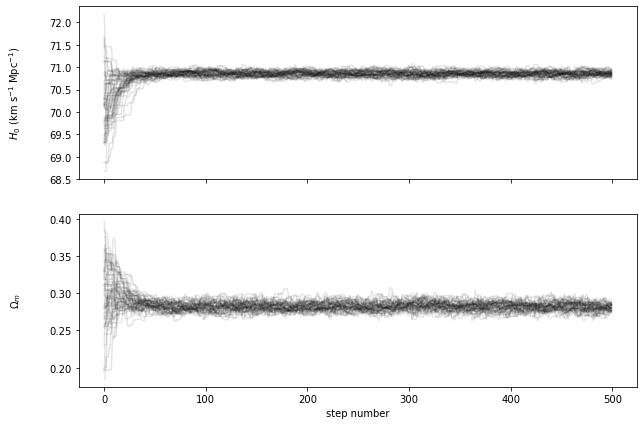

In [41]:
import copy

fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
samples = copy.deepcopy(sampler.chain)

#samples[:, :, 0] -= np.mean(samples[:, :, 0])
#samples[:, :, 1] -= np.median(samples[:, :, 1])

labels = [r"$H_0$ (km s$^{-1}$ Mpc$^{-1}$)", r"$\Omega_m$"]

for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.1)

    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

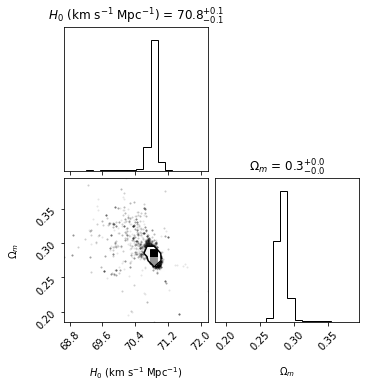

In [42]:
corner.corner(samples.reshape(-1, 2), show_titles=True, labels=labels,
              title_fmt='.1f'
             );

#numpy.reshape: dá uma nova forma a um array sem alterar os dados

# For a single lens

In [43]:
def log_likelihood(params):
    h0, om_m = params
    cosmo = FlatLambdaCDM(H0=h0, Om0=om_m)
    D_d = cosmo.angular_diameter_distance(z_lens[101]).value
    D_s = cosmo.angular_diameter_distance(z_source[101]).value
    D_ds = cosmo.angular_diameter_distance_z1z2(z_lens[101], z_source[101]).value
    
    D_d_r =  D_d
    D_dt_r = (1+z_lens[101])*(D_d * D_s / D_ds)
    
    return kde_lista[101].logLikelihood(D_d_r, D_dt_r)


def log_prior(params):
    h0, om_m = params
    
    if not 0. < h0 < 150.:
        return -np.inf
    
    if not 0.05 < om_m < 0.5:
        return -np.inf
    
    return 0.


def log_probability(params):
    prior = log_prior(params)
    
    if not np.isinf(prior):
        return log_likelihood(params) + prior
    else:
        return prior

In [44]:
import emcee
from multiprocessing import Pool

n_walkers, n_dim = 50, 2

with Pool(processes = 8) as pool:
    np.random.seed(1)
    pos = np.random.normal(loc=[70., 0.3], size=[n_walkers, n_dim], scale=[1, 5e-2]) 
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, pool = pool)

    state = sampler.run_mcmc(pos, 500, progress = True)

100%|██████████| 500/500 [00:06<00:00, 76.63it/s]


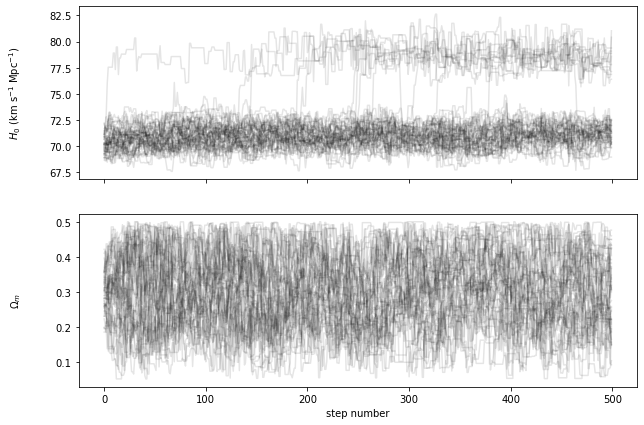

In [45]:
import copy

fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
samples = copy.deepcopy(sampler.chain)

#samples[:, :, 0] -= np.mean(samples[:, :, 0])
#samples[:, :, 1] -= np.median(samples[:, :, 1])

labels = [r"$H_0$ (km s$^{-1}$ Mpc$^{-1}$)", r"$\Omega_m$"]

for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.1)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

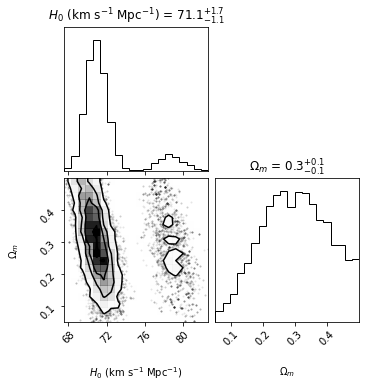

In [46]:
corner.corner(samples.reshape(-1, 2), show_titles=True, labels=labels,
              title_fmt='.1f'
             );